# Import Libraries


In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!git clone https://github.com/raghavrastogi75/Resume-parser-and-similarity-detection.git

Cloning into 'Resume-parser-and-similarity-detection'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 47 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.


# Install Spacy

In [4]:
!pip install spacy==2.1.4

     |████████████████████████████████| 29.8 MB 128 kB/s 
     |████████████████████████████████| 82 kB 340 kB/s 
     |████████████████████████████████| 3.2 MB 33.5 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 2.1 MB 29.5 MB/s 
  Attempting uninstall: preshed
    Found existing installation: preshed 3.0.6
    Uninstalling preshed-3.0.6:
      Successfully uninstalled preshed-3.0.6
  Attempting uninstall: plac
    Found existing installation: plac 1.1.3
    Uninstalling plac-1.1.3:
      Successfully uninstalled plac-1.1.3
  Attempting uninstall: blis
    Found existing installation: blis 0.4.1
    Uninstalling blis-0.4.1:
      Successfully uninstalled blis-0.4.1
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
  

# Create functions to convert Json file to Spacy format

In [5]:
# import logging
import json
import re

# JSON formatting functions
def json_to_spacy(JSON_FilePath):
    training_data = []
    lines=[]

    
    with open(JSON_FilePath, 'r') as f:
        lines = f.readlines()

    #For each json line
    for line in lines:
        data = json.loads(line)

        #add content key in data dictionary
        text = data['content'].replace("\n", " ")
        entities = []

        #add annotation key in dictionary
        data_annotations = data['annotation']
        if data_annotations is not None:
            for annotation in data_annotations:
                #only a single point in text annotation.
                point = annotation['points'][0]
                labels = annotation['label']
                # handle both list of labels or a single label.
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    p_start = point['start']
                    p_end = point['end']
                    p_text = point['text']

                    #find the left and right white spaces and remove them
                    lstrip_diff = len(p_text) - len(p_text.lstrip())
                    rstrip_diff = len(p_text) - len(p_text.rstrip())

                    #move the pointer for white spaces
                    if lstrip_diff != 0:
                        p_start = p_start + lstrip_diff
                    if rstrip_diff != 0:
                        p_end = p_end - rstrip_diff

                    #add the updates locations of the entities
                    entities.append((p_start, p_end + 1 , label))
        training_data.append((text, {"entities" : entities}))
    return training_data

def trim_entity_spans(data: list) -> list:
    #Removes leading and trailing white spaces from entity spans.
    #Returns The cleaned data.

    inval_span_tokens = re.compile(r'\s')

    tidy_data = []
    for text, annotations in data:
        entities = annotations['entities']
        val_entities = []
        for start, end, label in entities:
            val_start = start
            val_end = end

            # remove the whitespaces in the entity spans
            while val_start < len(text) and inval_span_tokens.match(
                    text[val_start]):
                val_start += 1
            while val_end > 1 and inval_span_tokens.match(
                    text[val_end - 1]):
                val_end -= 1
            val_entities.append([val_start, val_end, label])
        tidy_data.append([text, {'entities': val_entities}])
    return tidy_data

# Apply above conversion and cleaning on the training data

In [6]:
data = trim_entity_spans(json_to_spacy("/content/Resume-parser-and-similarity-detection/Entity Recognition in Resumes.json"))

data[0]


["Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

# Cleaning the Data - Remove overlapping entities

In [7]:
def clean_ents(training_data):
    
    clean_data = []
    for text, annotation in training_data:
        
        ents = annotation.get('entities')
        ents_copy = ents.copy()
        
        # append ent only if it is longer than its overlapping ent
        i = 0
        for ent in ents_copy:
            j = 0
            for overlapping_ent in ents_copy:
                # Skip self
                if i != j:
                    e_start, e_end, oe_start, oe_end = ent[0], ent[1], overlapping_ent[0], overlapping_ent[1]
                    # Delete any ent that overlaps, keep if longer
                    if ((e_start >= oe_start and e_start <= oe_end) \
                    or (e_end <= oe_end and e_end >= oe_start)) \
                    and ((e_end - e_start) <= (oe_end - oe_start)):
                        ents.remove(ent)
                j += 1
            i += 1
        clean_data.append((text, {'entities': ents}))
                
    return clean_data

data = clean_ents(data)
data[0]

("Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

### TRAINING NER SPACY MODEL

In [8]:
import random
import math

#splitting the train and test set

def train_test_split(data, test_size, random_state):

    random.Random(random_state).shuffle(data)
    test_idx = len(data) - math.floor(test_size * len(data))
    train_set = data[0: test_idx]
    test_set = data[test_idx: ]

    return train_set, test_set

In [9]:
train_data, test_data = train_test_split(data, test_size = 0.1, random_state = 42)

In [11]:
import spacy
import ast

f = open("/content/Resume-parser-and-similarity-detection/skill.txt", "r")
l = f.read()
patterns = l
res = ast.literal_eval(patterns)

def train_spacy():
    
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy

    # adding 'parser', 'ner','tagger' and 'entity_ruler' pipeline components
    if 'ner' not in nlp.pipe_names and 'parser' not in nlp.pipe_names and 'tagger' not in nlp.pipe_names:

        parser = nlp.create_pipe('parser')
        nlp.add_pipe(parser, last = True)

        tagger = nlp.create_pipe('tagger')
        nlp.add_pipe(tagger, last = True)

        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)

        ruler = nlp.create_pipe('entity_ruler')
        nlp.add_pipe(ruler, last = True)
        ruler.add_patterns(res)
        
        
    # add labels
    for _, annotations in train_data:
         for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    # get names of other pipes to disable them during training
    loss_arr = []
    #other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    #with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    for itn in range(20):
        print("Starting iteration " + str(itn))
        random.shuffle(train_data)
        losses = {}
        for text, annotations in train_data:
            nlp.update(
                [text],  # batch of texts
                [annotations],  # batch of annotations
                drop=0.2,  # dropout - make it harder to memorise data
                sgd=optimizer,  # callable to update weights
                losses=losses)
        loss_arr.append(losses["ner"])
        print(losses)
    return nlp,loss_arr

In [12]:
nlp, loss_arr = train_spacy()

Starting iteration 0
{'ner': 27211.581893905695, 'parser': 0.0, 'tagger': 7024.516697672401}
Starting iteration 1
{'tagger': 1.4154521414038034e-15, 'ner': 20836.490112870415, 'parser': 0.0}
Starting iteration 2
{'parser': 0.0, 'ner': 15331.152762017673, 'tagger': 1.2761128564772292e-15}
Starting iteration 3
{'parser': 0.0, 'ner': 15207.400146322589, 'tagger': 1.3471601110007777e-15}
Starting iteration 4
{'tagger': 1.4294221672040701e-15, 'parser': 0.0, 'ner': 12543.739808729071}
Starting iteration 5
{'ner': 12489.308025791363, 'tagger': 1.3175154635999354e-15, 'parser': 0.0}
Starting iteration 6
{'ner': 10816.047314717522, 'parser': 0.0, 'tagger': 1.2179964731526127e-15}
Starting iteration 7
{'ner': 10193.267294404986, 'tagger': 1.2562667569083176e-15, 'parser': 0.0}
Starting iteration 8
{'ner': 10176.086674260812, 'tagger': 1.249470143769561e-15, 'parser': 0.0}
Starting iteration 9
{'ner': 8329.482171575952, 'tagger': 1.2541008526650493e-15, 'parser': 0.0}
Starting iteration 10
{'par

[27211.581893905695, 20836.490112870415, 15331.152762017673, 15207.400146322589, 12543.739808729071, 12489.308025791363, 10816.047314717522, 10193.267294404986, 10176.086674260812, 8329.482171575952, 9253.783377666763, 8579.935027647536, 8158.401354687527, 8626.025235292658, 8319.998875695208, 6726.200886484337, 7177.658087336462, 9037.693819242337, 6638.384623042014, 7582.45701084406]


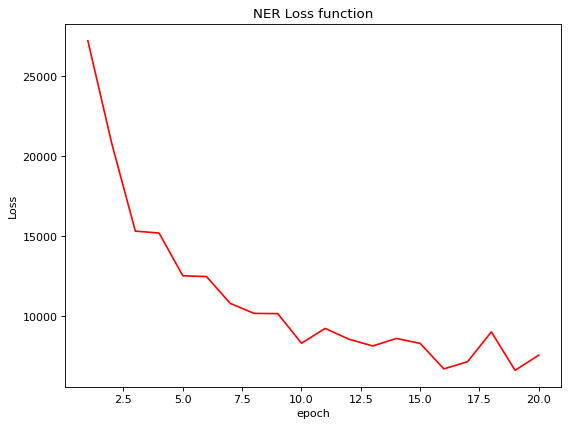

In [19]:
print(loss_arr)

import matplotlib.pyplot as plt
import numpy as np
loss_ar = np.array(loss_arr)

x = np.arange(1, 21)
y = loss_ar
 
# plotting
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.title("NER Loss function")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(x, y, color ="red")
plt.show()

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
#nlp.to_disk('/content/drive/My Drive/my_model')

In [22]:
import spacy

In [23]:
import pickle

pickle_out = open("nlp.pkl","wb")
pickle.dump(nlp,pickle_out)
pickle_out.close()

In [24]:
# nlp = spacy.load('/content/drive/My Drive/my_model')

# Finding accuracy of the model on the test set


In [25]:
from spacy.gold import GoldParse
from itertools import groupby

def doc_to_bilou(nlp, text):
    
    doc = nlp(text)
    tokens = [(tok.text, tok.idx, tok.ent_type_) for tok in doc]
    entities = []
    for entity, group in groupby(tokens, key=lambda t: t[-1]):
        if not entity:
            continue
        group = list(group)
        _, start, _ = group[0]
        word, last, _ = group[-1]
        end = last + len(word)
        
        entities.append((
                start,
                end,
                entity
            ))

    gold = GoldParse(nlp(text), entities = entities)
    pred_ents = gold.ner
    
    return pred_ents

y_test = []
y_pred = []

for text, annots in test_data:
    
    gold = GoldParse(nlp.make_doc(text), entities = annots.get("entities"))
    ents = gold.ner
    pred_ents = doc_to_bilou(nlp, text)
    
    y_test.append(ents)
    y_pred.append(pred_ents)
    
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from itertools import chain

def ner_report(y_true, y_pred):

    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_)
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset
    ), accuracy_score(y_true_combined, y_pred_combined)
    
report, accuracy = ner_report(y_test, y_pred)
print(report)

                       precision    recall  f1-score   support

                    -       0.00      0.00      0.00       142
       B-College Name       0.76      0.78      0.77        32
       I-College Name       0.78      0.71      0.74        63
       L-College Name       0.70      0.72      0.71        32
       U-College Name       0.00      0.00      0.00         1
B-Companies worked at       0.73      0.37      0.49        30
I-Companies worked at       0.03      0.25      0.05         4
L-Companies worked at       0.67      0.33      0.44        30
U-Companies worked at       0.36      0.29      0.32        41
             B-Degree       0.91      0.83      0.87        24
             I-Degree       0.95      0.92      0.94        66
             L-Degree       0.91      0.83      0.87        24
             U-Degree       0.33      0.67      0.44         3
        B-Designation       0.70      0.79      0.74        47
        I-Designation       0.82      0.57      0.68  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(accuracy)

0.8814494170215736


### Testing data

In [27]:
!pip install PyMuPDF

     |████████████████████████████████| 8.8 MB 4.1 MB/s 


In [49]:
import sys, fitz
fname = '/content/Resume-parser-and-similarity-detection/KartikUllal_resume.pdf'
doc = fitz.open(fname)
doc

Document('/content/Resume-parser-and-similarity-detection/KartikUllal_resume.pdf')

In [50]:
text = ''
for page in doc:
    text = text + str(page.get_text())
tx = " ".join(text.split('\n'))
tx

"Kartik Ullal Boston, MA 02215 ∙ (857) 334-3460 kartikullal99@gmail.com ∙ www.linkedin.com/in/kartikullal ∙ Portfolio Website EDUCATION Master's of Science, Data Science Expected May 2023 Northeastern University, Khoury College of Computer Sciences, Boston CGPA: 3.78/4 ● Related Courses: Linear Algebra and probability for Data Science, Algorithms, Introduction to Data Management and Processing, Supervised Machine Learning, Natural Language Processing Bachelor's in Engineering, Information Technology June 2021 Mumbai University, Thadomal Shahani Engineering College(TSEC), Mumbai CGPA: 3.71/4 (9.18/10) ● Related Courses: Database Management Systems, Data Mining and Business Intelligence, Artificial Intelligence, Big Data Analytics, Object Oriented Programming  EXPERIENCE Web Developer Intern June 2020 - July 2020 Prayaas Corps, Jaipur, Rajasthan ● Developed a Covid-19 webpage to showcase work done for people during the Covid-19 crisis using HTML5, CSS3, and WordPress ● Collaborated with 

In [51]:
doc = nlp(tx)
print(doc)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

Kartik Ullal Boston, MA 02215 ∙ (857) 334-3460 kartikullal99@gmail.com ∙ www.linkedin.com/in/kartikullal ∙ Portfolio Website EDUCATION Master's of Science, Data Science Expected May 2023 Northeastern University, Khoury College of Computer Sciences, Boston CGPA: 3.78/4 ● Related Courses: Linear Algebra and probability for Data Science, Algorithms, Introduction to Data Management and Processing, Supervised Machine Learning, Natural Language Processing Bachelor's in Engineering, Information Technology June 2021 Mumbai University, Thadomal Shahani Engineering College(TSEC), Mumbai CGPA: 3.71/4 (9.18/10) ● Related Courses: Database Management Systems, Data Mining and Business Intelligence, Artificial Intelligence, Big Data Analytics, Object Oriented Programming  EXPERIENCE Web Developer Intern June 2020 - July 2020 Prayaas Corps, Jaipur, Rajasthan ● Developed a Covid-19 webpage to showcase work done for people during the Covid-19 crisis using HTML5, CSS3, and WordPress ● Collaborated with S

### Extract Skills


In [52]:
def extract_spacy():
    
    nlp1 = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'entity_ruler' not in nlp1.pipe_names:

        ruler = nlp1.create_pipe('entity_ruler')
        nlp1.add_pipe(ruler, last = True)
        ruler.add_patterns(res) 

    return nlp1

    

In [53]:
extract = extract_spacy()

In [54]:
doc = extract(tx)
print(doc)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

Kartik Ullal Boston, MA 02215 ∙ (857) 334-3460 kartikullal99@gmail.com ∙ www.linkedin.com/in/kartikullal ∙ Portfolio Website EDUCATION Master's of Science, Data Science Expected May 2023 Northeastern University, Khoury College of Computer Sciences, Boston CGPA: 3.78/4 ● Related Courses: Linear Algebra and probability for Data Science, Algorithms, Introduction to Data Management and Processing, Supervised Machine Learning, Natural Language Processing Bachelor's in Engineering, Information Technology June 2021 Mumbai University, Thadomal Shahani Engineering College(TSEC), Mumbai CGPA: 3.71/4 (9.18/10) ● Related Courses: Database Management Systems, Data Mining and Business Intelligence, Artificial Intelligence, Big Data Analytics, Object Oriented Programming  EXPERIENCE Web Developer Intern June 2020 - July 2020 Prayaas Corps, Jaipur, Rajasthan ● Developed a Covid-19 webpage to showcase work done for people during the Covid-19 crisis using HTML5, CSS3, and WordPress ● Collaborated with S

### Job Description Similarity

In [55]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
import os
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [56]:

# This is a function to extract skills from the resume-parser dataset to train Doc2Vec model
def get_skills(data):
    temp_skill = []
    #generate a 2-D list skills and name from the resume
    for j in data:
        if j['label'] == ['Skills']:
            temp_skill.append(j['points'][0]['text'])
        if j['label'] == ['Name']:
            temp_name = j['points'][0]['text']
        else:
            temp_name = "No name"

    #clean the list of skills
    for i,j in enumerate(temp_skill):
        j = j.replace("•","")
        j = j.replace('\n',",")
        j = re.sub("[^A-Za-z0-9+-, ]","",j)
        j = j.split(',')
        j = [x for x in j if x!= '']
        temp_skill[i] = j
        
    temp_s = []

    #Convert the 2-D list into a 1-D list
    for j in temp_skill:
        for i in j:
            temp_s.append(i)

    
    return (temp_name, temp_s)


In [57]:
skills = {}
df = pd.read_json('/content/Resume-parser-and-similarity-detection/Entity Recognition in Resumes.json', lines = True)
data = df["annotation"]
#Create a dictionary of skills with key as name and value as the list of skills
for i in data:
    name,skill = get_skills(i)
    skills[name] = skill


Cosine Similarity function


In [58]:
#This is a function to calculate cosine similarity between 2 vectors
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

Doc2Vec


In [59]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# This is a function to train the doc2vec model using the skills dictionary
def doc2vec_similarity_train(skills):
    tokenized_dict = {}

    # Here we create a tokenized dictionary with key as name and values as tokens from the skills
    for n,s in skills.items():
        tokenized_list = []
        for i in s:
            x = word_tokenize(i.lower())
            for j in x:
                tokenized_list.append(j)
        tokenized_dict[n] = tokenized_list
    
    # This tags each document (tokens of skills) to feed to the Doc2Vec model as input
    tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_dict.values())]

    # we create the doc2Vec model that outputs a vector of length 40. 
    # Window size = 3 for the continours bag of words
    # We don't count words with count less than 1 
    # and we train for 100 epochs
    model = Doc2Vec(vector_size=40,window = 3, min_count = 1, epochs = 100)
    
    #build and train the model
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    
    return model

#this is a function to test the job requirement and resume skills and output similarity
def doc2vec_similarity_test(model, req, skill):
    tokenized_req = []
    tokenized_skill = []
    #tokenizes the job requirements
    for i in req:
        x = word_tokenize(i.lower())
        for j in x:
                tokenized_req.append(j)
    #tokenizes the resume skills
    for i in skill:
        x = word_tokenize(i.lower())
        for j in x:
                tokenized_skill.append(j)
    
    #calculates vector for resume skills
    skill_vector = model.infer_vector(tokenized_skill)
    #calculates vector for job requirement skills
    req_vector = model.infer_vector(tokenized_req)
    
    #calculates similarity
    similarity = cosine(skill_vector, req_vector)
    
    return similarity
    

In [60]:
#train the model with the skills dictionary
model = doc2vec_similarity_train(skills)


Sentence Transformers


In [61]:
pip install -U sentence-transformers

In [62]:
from sentence_transformers import SentenceTransformer

#this is a function to calculate similarity using sentence-bert

def sentence_bert_similarity(req, skill):
    #Here we use and import pre trained sentence bert model 
    sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    
    # here we are converting the skills into a single string
    req = ",".join(req)
    skill = ",".join(skill)
    
    #calculating the vectors for resume and job description
    skill_vec = sbert_model.encode([skill])[0]
    req_vec = sbert_model.encode([req])[0]
    
    #calculate similarity
    similarity = cosine(skill_vec, req_vec)
    
    return similarity

In [63]:
#get user skills from trained NER model
user_skills = [i.text for i in doc.ents]

In [64]:
#function to clean and preprocess job description 
def clean_job(description):
  description = description.lower()
  description= description.replace("•"," ")
  description = description.replace('\n',",")
  description = re.sub("[^A-Za-z0-9,]"," ",description)

  return description



Data Science Job description

In [65]:
#job description for data science role
job_req = "To qualify you must have a 1. Masters degree in a quantitative discipline (Biomedical Informatics, Computer Science, Machine Learning, Applied Statistics, Mathematics or similar field, Proficiency in at least one programming language (Python, R) and machine learning tools (scikit learn, R), Knowledge of predictive modeling and machine learning concepts, including design, development, evaluation, deployment and scaling to large datasets, Familiarity with computing models for big data Hadoop / MapReduce, Spark etc., Knowledge of databases (Relational / SQL, NOSQL, MongoDB, etc.), Good grasp of software engineering principles. Experience in integrating modern software architectures, Knowledge and some experience in operational aspects of software development and deployment, including automation, testing, virtualization and container technology, Knowledge of clinical and operational aspects of healthcare delivery, Excellent written and oral communication skills for a variety of audiences, Preferred Qualifications, PhD degree in a quantitative field (Biomedical Informatics, Computer Science, Machine Learning, Applied Statistics, Mathematics or similar field) + 2 years experience, Demonstrated skills in design and implementation of complex machine learning models, Demonstrated knowledge of software engineering and operational skills through prior projects."

job_req = clean_job(job_req)
 
print(job_req)

# run the ner model on the job description and extract the skills
doc = extract(job_req)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

job_skills = [i.text for i in doc.ents]


#similarity using sentence_bert
print(sentence_bert_similarity(job_skills, user_skills))

#similarity using doc2vec
print(doc2vec_similarity_test(model, job_skills,user_skills))


to qualify you must have a 1  masters degree in a quantitative discipline  biomedical informatics, computer science, machine learning, applied statistics, mathematics or similar field, proficiency in at least one programming language  python, r  and machine learning tools  scikit learn, r , knowledge of predictive modeling and machine learning concepts, including design, development, evaluation, deployment and scaling to large datasets, familiarity with computing models for big data hadoop   mapreduce, spark etc , knowledge of databases  relational   sql, nosql, mongodb, etc  , good grasp of software engineering principles  experience in integrating modern software architectures, knowledge and some experience in operational aspects of software development and deployment, including automation, testing, virtualization and container technology, knowledge of clinical and operational aspects of healthcare delivery, excellent written and oral communication skills for a variety of audiences, 

Software Engineering Job Description


In [66]:
#job description for software engineer role
job_req = "Computer Science, Engineering or related degree with a minimum GPA of 3.0 or higher Software engineering skills and experience with some of the following technologies: Java, .NET, Node.js, Python, Angular, React, AWS, Azure, GCP, SQL or mobile Knowledge of common data structures and algorithmsStrong problem-solving and software triage skills with the ability to work cross-functionally in a fast-paced and rapidly changing work environment Strong analytical and interpersonal communication skills"

job_req = clean_job(job_req)

print(job_req)

# run the ner model on the job description and extract the skills
doc = extract(job_req)
for ent in doc.ents:
    print(f'{ent.label_.upper():{30}}- {ent.text}')

job_skills = [i.text for i in doc.ents]

#similarity using sentence_bert
print(sentence_bert_similarity(job_skills, user_skills))

#similarity using doc2vec
print(doc2vec_similarity_test(model, job_skills,user_skills))

computer science, engineering or related degree with a minimum gpa of 3 0 or higher software engineering skills and experience with some of the following technologies  java,  net, node js, python, angular, react, aws, azure, gcp, sql or mobile knowledge of common data structures and algorithmsstrong problem solving and software triage skills with the ability to work cross functionally in a fast paced and rapidly changing work environment strong analytical and interpersonal communication skills
SKILL                         - computer science
SKILL                         - engineering
SKILL                         - software engineering
SKILL                         - java
SKILL                         - node js
SKILL                         - python
SKILL                         - angular
SKILL                         - react
SKILL                         - azure
SKILL                         - mobile
SKILL                         - data structures
SKILL                         - soft